Code by: **Fiona Chow and Jennah Gosciak**
* We are auditing the ADS with a public GitHub repo is here: https://github.com/jennahgosciak/algaebloom
* The original GitHub repository associated with this competition is here: https://github.com/apwheele/algaebloom

**Install and Load Libraries/Files**

In [1]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
# os.getcwd()
# os.chdir('/Users/fionachow/Documents/NYU/CDS/Spring 2023/1017 - Responsible Data Science/Project/algaebloom/data')
import geopandas as gpd
from census import Census
from us import states
import numpy as np
from tabulate import tabulate

In [3]:
satellite_data = pd.read_csv('../data/sat.csv')
elevation_data = pd.read_csv('../data/elevation_dem.csv')
metadata = pd.read_csv('../data/metadata.csv')

train = pd.read_csv('../data/train_labels.csv')
algae_acs = pd.read_csv('../data/algae_pts_with_tracts.csv')
spat_lag = pd.read_csv('../data/spat_lag.csv')
split_pred = pd.read_csv('../data/split_pred.csv')
submission_fmt = pd.read_csv('../data/submission_format.csv')

# Code for Input/Output Section
* Includes EDA on all input datasets and code for generating figures

**EDA for Metadata**

In [4]:
#count of training labels
train_count = metadata[metadata['split'] == 'train']['split'].value_counts()
#count of test labels
test_count = metadata[metadata['split'] == 'test']['split'].value_counts()

print(train_count)
print("----------")
print(test_count)

train    17060
Name: split, dtype: int64
----------
test    6510
Name: split, dtype: int64


In [5]:
#metadata types
metadata_train = metadata.loc[metadata['split']=='train']

metadata_train.dtypes

uid           object
latitude     float64
longitude    float64
date          object
split         object
dtype: object

C:\Users\Jennah\AppData\Local\Temp\ipykernel_18452\3514872982.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train['date_fmt'] = pd.to_datetime(metadata_train['date'])


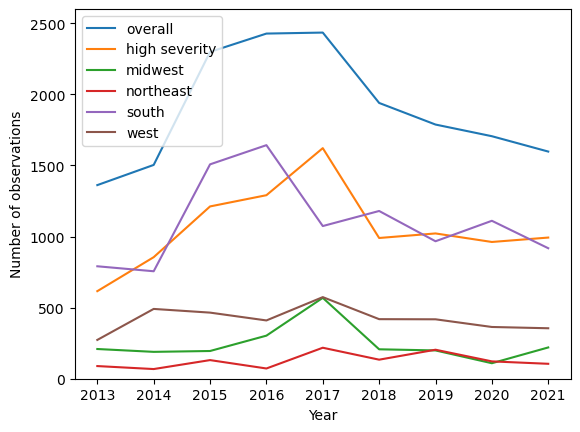

In [6]:
#Figure 1: Number of training data observations by year

train['severity_bin'] = np.where(train['density'] >= 20000, 'high', 'low')
metadata_train['date_fmt'] = pd.to_datetime(metadata_train['date'])
metadata_train_plot_df = pd.merge(train, metadata_train, on = "uid")
train['severity_bin'].value_counts(normalize=True)
metadata_train_plot_df['region'].unique()

metadata_train_plot_df['date_fmt'].dt.year.value_counts().sort_index().plot(
    rot=45, label = 'overall'
)
metadata_train_plot_df.loc[metadata_train_plot_df['severity_bin'] == 'high',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'high severity'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'midwest',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'midwest'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'northeast',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'northeast'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'south',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'south'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'west',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'west'
)
plt.ylim(0,2600)
plt.ylabel('Number of observations')
plt.xlabel('Year')
plt.legend()
plt.show();

**EDA for Training Data**

Notes from DrivenData:
* severity (int): severity level based on the cyanobacteria density
* density (float): raw measurement of total cyanobacteria density in cells per mL. Participants should submit predictions for severity level, NOT for the raw cell density value in cells per milliliter (mL). See the Submission format section.


Train columns: ['uid' 'region' 'severity' 'density' 'severity_bin']


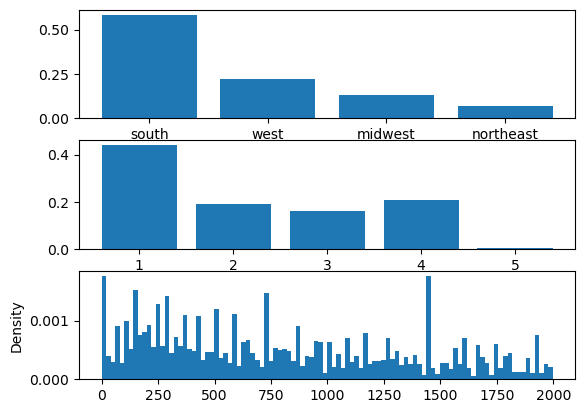

In [7]:
#Figure 2: Value distributions of input features from training labels
print("Train columns:", train.columns.values)
fig, axs = plt.subplots(3,1)
axs[0].bar(train['region'].value_counts(normalize=True).index,
           train['region'].value_counts(normalize=True))
axs[1].bar(train['severity'].value_counts(normalize=True).index,
            train['severity'].value_counts(normalize=True))
axs[2].hist(train.loc[train['density'] < 2000, 'density'], bins=100, density=True)
plt.ylabel('Density')
plt.show()

In [8]:
#training data types
train.dtypes

uid              object
region           object
severity          int64
density         float64
severity_bin     object
dtype: object

**EDA for Elevation Data**

In [9]:
#elevation data types
elevation_data.dtypes

latitude     float64
longitude    float64
box            int64
elevation    float64
mine         float64
maxe         float64
dife         float64
avge         float64
stde         float64
uid           object
DateTime      object
dtype: object

In [10]:
#elevation data info
elevation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   23570 non-null  float64
 1   longitude  23570 non-null  float64
 2   box        23570 non-null  int64  
 3   elevation  23570 non-null  float64
 4   mine       23570 non-null  float64
 5   maxe       23570 non-null  float64
 6   dife       23570 non-null  float64
 7   avge       23570 non-null  float64
 8   stde       23570 non-null  float64
 9   uid        23570 non-null  object 
 10  DateTime   23570 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB


In [11]:
#finding missing values by filtering for -99999 values as he documented using dife = -99999 for missing elevation data
elevation_data_describe = elevation_data[elevation_data['dife']== -99999].any(axis=1)

elevation_data_describe.describe()

count       0
unique      0
top       NaN
freq      NaN
dtype: object

Text(0, 0.5, 'Count')

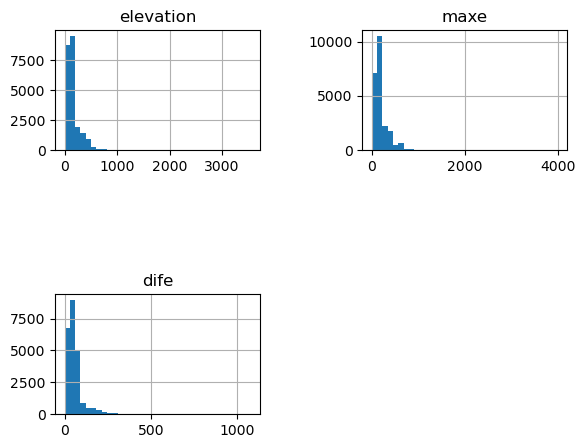

In [12]:
#Figure 3 - Plotting value distributions of input features for elevation data
elevation_data_input_features = elevation_data.drop(columns = ['latitude','longitude','box','avge','stde','mine'])
elevation_data_input_features.hist(bins=35)
plt.xlim(0, 1000)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=1.2)
plt.ylabel('Count')

In [13]:
#elevation data statistics
elevation_data.describe()

,latitude,longitude,box,elevation,mine,maxe,dife,avge,stde
count,23570.000000,23570.000000,23570.0,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000
mean,37.599112,-91.438307,1000.0,175.416188,159.612456,218.089806,58.477350,182.174718,11.890973
std,2.823860,17.886877,0.0,273.668598,269.082678,296.131317,55.980386,278.927905,13.567918
min,26.389430,-124.179200,1000.0,-6.573961,-8.489909,0.000000,0.000000,-5.039981,0.000000
25%,35.700925,-109.370945,1000.0,56.113747,45.532188,97.374672,23.930344,65.147533,4.125027
50%,36.228150,-79.268000,1000.0,124.059055,98.498672,162.546829,51.229195,127.206436,9.250443
75%,38.930270,-79.026108,1000.0,180.500000,173.500000,229.550110,68.817337,184.266804,13.593365
max,48.973250,-67.698650,1000.0,3547.000000,3365.940430,3988.470703,1078.071045,3618.695068,213.942810


C:\Users\Jennah\AppData\Local\Temp\ipykernel_18452\2425464916.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  elevation_correlation = elevation_data_input_features.corr()


<Axes: >

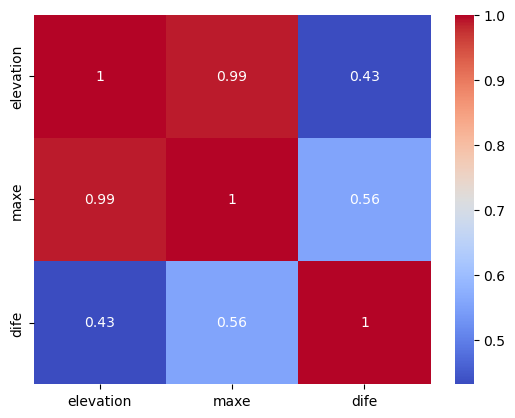

In [14]:
#Figure 4 - Elevation data correlation
elevation_correlation = elevation_data_input_features.corr()
sns.heatmap(elevation_correlation,annot=True, cmap='coolwarm')

**EDA for Satellite Data**

In [15]:
#satellite data statistics
satellite_data.describe()

,prop_lake_500,r_500,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500
count,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000,9353.000000
mean,0.291860,128.186468,118.186496,90.797906,0.273842,132.651309,120.987224,93.590110,0.255629,135.830224,122.344628,95.336929
std,0.184878,56.880383,48.595939,48.111461,0.176043,53.732413,45.918708,46.179445,0.160341,50.024667,42.884688,43.941418
min,0.001277,1.000000,1.000000,1.000000,0.000335,1.000000,1.000000,1.000000,0.000042,1.000000,1.000000,1.000000
25%,0.146154,84.334898,85.383862,56.983360,0.140635,90.426307,88.539080,60.687841,0.137606,98.934404,94.342031,65.641969
50%,0.257959,123.855156,111.767442,81.297004,0.233766,131.699970,115.959786,84.940215,0.217252,136.133842,119.375113,88.279942
75%,0.409261,171.143348,145.612996,111.635373,0.375878,173.576494,148.949142,116.391888,0.344484,171.698004,147.204473,115.580552
max,1.000000,255.000000,255.000000,255.000000,1.000000,255.000000,255.000000,255.000000,1.000000,255.000000,255.000000,255.000000


In [16]:
#satellite data types and data info
satellite_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   imtype          9353 non-null   object 
 1   prop_lake_500   9353 non-null   float64
 2   r_500           9353 non-null   float64
 3   g_500           9353 non-null   float64
 4   b_500           9353 non-null   float64
 5   prop_lake_1000  9353 non-null   float64
 6   r_1000          9353 non-null   float64
 7   g_1000          9353 non-null   float64
 8   b_1000          9353 non-null   float64
 9   prop_lake_2500  9353 non-null   float64
 10  r_2500          9353 non-null   float64
 11  g_2500          9353 non-null   float64
 12  b_2500          9353 non-null   float64
 13  uid             9353 non-null   object 
 14  DateTime        9353 non-null   object 
dtypes: float64(12), object(3)
memory usage: 1.1+ MB


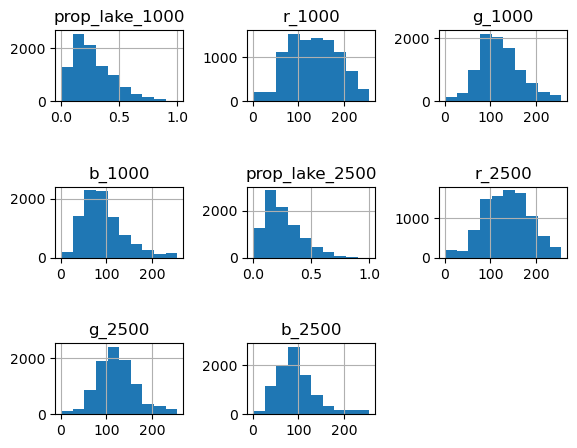

In [17]:
#Figure 5 - Plotting value distributions of input features for satellite data
satellite_data_input_features = satellite_data.drop(columns = ['prop_lake_500','r_500','g_500','b_500'])
satellite_data_input_features.hist()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=1.2)

In [18]:
#finding missing values by filtering for -1 values as he documented using .fillna(-1) for missing satelite data
satellite_data[(satellite_data==-1).any(axis=1)]

,imtype,prop_lake_500,r_500,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500,uid,DateTime


C:\Users\Jennah\AppData\Local\Temp\ipykernel_18452\1807249570.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sat_correlation = satellite_data_input_features.corr()


<Axes: >

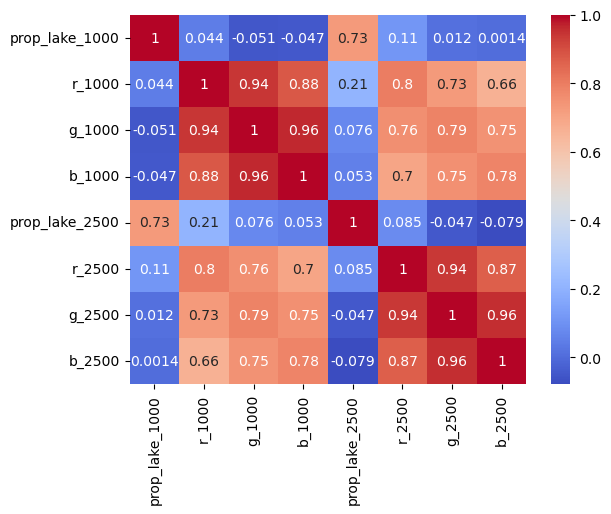

In [19]:
#Figure 6: Correlation of input features from satellite images
sat_correlation = satellite_data_input_features.corr()
sns.heatmap(sat_correlation, annot=True, cmap='coolwarm')

**EDA for Output Data**

**Important note from DrivenData:** "Each geographic area is either entirely in the train set or entirely in the test set. This means that none of the test set locations are in the training data, so your model's performance will be measured on unseen locations."

What should we consider to be severe?
* From this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4014740/#:~:text=In%20particular%2C%20Cyanobacteria%20may%20be,water%20and%20decreases%20its%20transparency): "At times, the phenomenon is so obvious, that the naked eye can see the mass of microscopic algae, which produce blooms giving a particular coloring to the water body. The term “algal blooms” indicates a situation in which 80%–90% of the mass of microscopic algae consists of one or two species. In particular, Cyanobacteria may be considered as blooming when their cell number exceeds one million per liter. This coating of microscopic algae covers the surface of the water and decreases its transparency. This, in turn, prevents the penetration of sunlight, something that, coupled with the thermal stratification typical of reservoirs in the Mediterranean area, inevitably engenders conditions of anoxia and, hence, the above-mentioned consequence"
* Some background from this [article](https://www.nature.com/articles/s41598-019-54453-y): "Cyanobacterial harmful algal blooms (cyanoHABs) are a serious environmental, water quality and public health issue worldwide because of their ability to form dense biomass and scum and to produce toxins such as neurotoxins (anatoxin-a), hepatotoxins (microcystins), and cytotoxins (cylindrospermospin)1. Cyanotoxins are capable of causing a wide variety of adverse human health issues including gastrointestinal distress, dermatitis, liver failure, or even death of domestic and livestock animals when they are exposed to water with toxins from intense cyanoHABs2,3. CyanoHABs are considered to be increasing globally over the past few decades although observations are quite limited4,5. The frequency and magnitude of these blooms are expected to worsen in the future with increased surface water temperatures and vertical stratification6. In addition, cyanoHAB growth and intensity are known to be affected by weather-driven environmental and anthropogenic factors, such as shifts in rainfall patterns with climatology and changing agricultural practices."
    * "Based on the [World Health Organization’s (WHO)](https://www.who.int/publications/m/item/toxic-cyanobacteria-in-water---second-edition) cell abundance threshold, three magnitude classes were considered for categorizing lakes as Low (≤20,000 cells mL−1), Moderate (20,000 ≤ cells mL−1 ≤ 100,000), and High (>100,000 cells mL−1) exposure health risk"

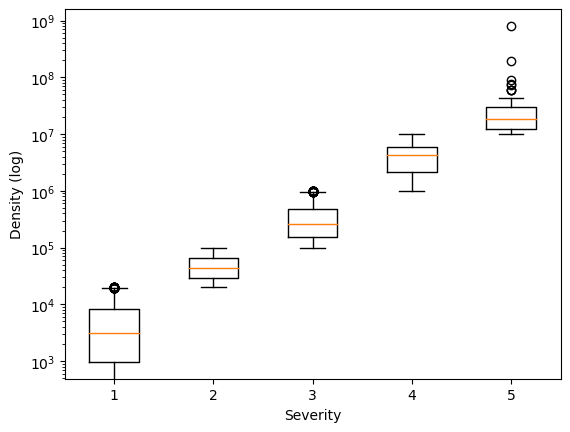

In [20]:
#Figure 7: Range of density values for each severity level
plt.boxplot([train.loc[train['severity']==x,'density'] for x in range(1,6)])
plt.yscale('log')
plt.xticks(rotation=0)
plt.ylabel('Density (log)')
plt.xlabel('Severity')
plt.show();

In [21]:
#density distribution
print("severity over 1,000,000:", np.mean(train['density'] > 1000000))
print("severity over 100,000:", np.mean(train['density'] > 100000))
print("severity over 20,000:", np.mean(train['density'] > 20000))

severity over 1,000,000: 0.21131301289566237
severity over 100,000: 0.3705744431418523
severity over 20,000: 0.5604923798358734


In [22]:
#classifying densities into high/low severities
train['severity_bin'] = np.where(train['density'] >= 20000, 'high', 'low')
train['severity_bin'].value_counts(normalize=True)



high    0.560551
low     0.439449
Name: severity_bin, dtype: float64

In [23]:
#proportion of severity bins with severity levels
train[['severity_bin','severity']].value_counts(normalize=True)

severity_bin  severity
low           1           0.439449
high          4           0.207913
              2           0.189859
              3           0.159379
              5           0.003400
dtype: float64

In [24]:
#covert to latex
train[['severity_bin','severity']].value_counts(normalize=True).reset_index().style.to_latex()

'\\begin{tabular}{llrr}\n & severity_bin & severity & 0 \\\\\n0 & low & 1 & 0.439449 \\\\\n1 & high & 4 & 0.207913 \\\\\n2 & high & 2 & 0.189859 \\\\\n3 & high & 3 & 0.159379 \\\\\n4 & high & 5 & 0.003400 \\\\\n\\end{tabular}\n'

In [25]:
#distribution of severity bins per region
mgd_severity_counts = pd.merge(train[['region', 'severity_bin']].value_counts().reset_index(drop=False).sort_values(['region', 'severity_bin']).rename({0:'count'}, axis=1),
         train['region'].value_counts().reset_index(drop=False).rename({'region':'total', 'index':'region'},axis=1),
         on='region')
mgd_severity_counts['pct'] = mgd_severity_counts['count']/mgd_severity_counts['total']
mgd_severity_counts['pct_total'] = mgd_severity_counts['count']/sum(mgd_severity_counts['total'])
mgd_severity_counts


,region,severity_bin,count,total,pct,pct_total
0,midwest,high,1419,2200,0.645000,0.041589
1,midwest,low,781,2200,0.355000,0.022890
2,northeast,high,587,1143,0.513561,0.017204
3,northeast,low,556,1143,0.486439,0.016295
4,south,high,3949,9948,0.396964,0.115739
5,south,low,5999,9948,0.603036,0.175821
6,west,high,3608,3769,0.957283,0.105744
7,west,low,161,3769,0.042717,0.004719


## Downloading Census Data

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import numpy as np
import config

In [27]:
c = Census(config.census_api)
states

<module 'us.states' from 'c:\\Users\\Jennah\\anaconda3\\envs\\bloom\\lib\\site-packages\\us\\states.py'>

In [28]:
state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

In [29]:
census_dfs = []
for i in state_codes:
    census_dfs.append(c.acs5.state_county_tract(fields = ('NAME', 'B19019_001E', 'B02001_001E', 'B16009_002E', 'B01003_001E', 'B02001_002E', 'B02001_003E',
                                                          'B02001_003E', 'B02001_005E', 'B03001_003E'),
                                      state_fips = state_codes[i],
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2019))

In [30]:
census_df = pd.concat([pd.DataFrame(x) for x in census_dfs], axis=0).rename({'B19019_001E': 'median_household_income',
                                                                             'B02001_001E': 'total_pop_race',
                                                                             'B16009_002E': 'poverty',
                                                                             'B01003_001E': 'total_pop',
                                                                             'B02001_002E': 'white',
                                                                             'B02001_003E': 'black',
                                                                             'B02001_005E': 'asian',
                                                                             'B03001_003E': 'hispanic_latino'
                                                                             }, axis=1)
census_df

,NAME,median_household_income,total_pop_race,poverty,total_pop,white,black,asian,hispanic_latino,state,county,tract
0,"Census Tract 416, Clark County, Washington",37083.0,3486.0,606.0,3486.0,2282.0,351.0,80.0,1033.0,53,011,041600
1,"Census Tract 430, Clark County, Washington",61771.0,1993.0,164.0,1993.0,1706.0,41.0,96.0,444.0,53,011,043000
2,"Census Tract 408.05, Clark County, Washington",98911.0,6981.0,510.0,6981.0,6362.0,48.0,224.0,300.0,53,011,040805
3,"Census Tract 404.03, Clark County, Washington",92546.0,4204.0,292.0,4204.0,3967.0,115.0,63.0,174.0,53,011,040403
4,"Census Tract 406.04, Clark County, Washington",88561.0,5810.0,301.0,5810.0,4852.0,79.0,253.0,651.0,53,011,040604
...,...,...,...,...,...,...,...,...,...,...,...,...
217,"Census Tract 9659, Clay County, South Dakota",32385.0,6131.0,1592.0,6131.0,5223.0,221.0,205.0,239.0,46,027,965900
218,"Census Tract 9543.01, Codington County, South ...",40701.0,4577.0,882.0,4577.0,4226.0,43.0,45.0,71.0,46,029,954301
219,"Census Tract 9543.02, Codington County, South ...",79727.0,5098.0,189.0,5098.0,4914.0,127.0,34.0,34.0,46,029,954302
220,"Census Tract 9545.01, Codington County, South ...",49348.0,2492.0,433.0,2492.0,2243.0,8.0,7.0,130.0,46,029,954501


In [31]:
census_df.shape

(74001, 12)

In [32]:
tract_shape = []
for i in state_codes:
    tract_shape.append(gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_codes[i]}_tract.zip"))

In [33]:
tract_gdf = pd.concat(tract_shape, axis=0).reset_index()
tract_gdf

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,0,53,049,950800,53049950800,9508,Census Tract 9508,G5020,S,42157200,107412602,+46.5827228,-124.0272568,"POLYGON ((-124.08567 46.71716, -124.08256 46.7..."
1,1,53,061,051701,53061051701,517.01,Census Tract 517.01,G5020,S,2491298,0,+47.8299704,-122.2999369,"POLYGON ((-122.31500 47.82142, -122.31498 47.8..."
2,2,53,061,051918,53061051918,519.18,Census Tract 519.18,G5020,S,4477551,0,+47.7834467,-122.2143909,"POLYGON ((-122.23305 47.78378, -122.23304 47.7..."
3,3,53,061,052006,53061052006,520.06,Census Tract 520.06,G5020,S,1932452,0,+47.8494718,-122.1963226,"POLYGON ((-122.20972 47.84538, -122.20963 47.8..."
4,4,53,061,052105,53061052105,521.05,Census Tract 521.05,G5020,S,51597252,3007422,+47.8770813,-122.0961284,"POLYGON ((-122.18909 47.92844, -122.18611 47.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,217,46,081,966301,46081966301,9663.01,Census Tract 9663.01,G5020,S,121953995,301439,+44.5510342,-103.9491554,"POLYGON ((-104.05597 44.56310, -104.05595 44.5..."
73997,218,46,081,966600,46081966600,9666,Census Tract 9666,G5020,S,1080589898,156413,+44.2609032,-103.7870725,"POLYGON ((-104.05563 44.36380, -104.05563 44.3..."
73998,219,46,011,958600,46011958600,9586,Census Tract 9586,G5020,S,933997276,6323802,+44.3767751,-096.5957541,"POLYGON ((-96.75838 44.19721, -96.75739 44.207..."
73999,220,46,011,959000,46011959000,9590,Census Tract 9590,G5020,S,12725733,216908,+44.2768342,-096.7748038,"POLYGON ((-96.78859 44.30193, -96.78858 44.302..."


In [34]:
# load algae data
algae = pd.read_csv("../data/metadata.csv")
algae.loc[algae['split']=='train'].shape

(17060, 5)

In [35]:
# create geodataframe
algae_gdf = gpd.GeoDataFrame(
    algae, geometry=gpd.points_from_xy(algae['longitude'], algae['latitude'], crs=4326)).to_crs(4269)
algae_gdf

,uid,latitude,longitude,date,split,geometry
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032)
1,aabn,36.559700,-121.510000,2016-08-31,test,POINT (-121.51000 36.55970)
2,aacd,35.875083,-78.878434,2020-11-19,train,POINT (-78.87843 35.87508)
3,aaee,35.487000,-79.062133,2016-08-24,train,POINT (-79.06213 35.48700)
4,aaff,38.049471,-99.827001,2019-07-23,train,POINT (-99.82700 38.04947)
...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,POINT (-121.74900 36.70850)
23566,zzwo,39.792190,-99.971050,2017-06-19,train,POINT (-99.97105 39.79219)
23567,zzwq,35.794000,-79.012551,2015-03-24,train,POINT (-79.01255 35.79400)
23568,zzyb,35.742000,-79.238600,2016-11-21,train,POINT (-79.23860 35.74200)


In [58]:
algae_mgd = algae_gdf.sjoin(tract_gdf, how="left")

In [59]:
# check total missing values (to fix later)
algae_mgd['GEOID'].isna().sum()

414

In [38]:
def calculate_nearest_tract(row, tracts):
    """Calculate distance to nearest tract using the argmin distance"""
    print(row)
    distances = tracts.distance(row)
    return tracts.iloc[np.argmin(distances)]['GEOID']
tract_gdf_proj = tract_gdf.to_crs(3857)
# for those that are missing as a result of the spatial join, calculate GEOID with the smallest (argmin) distance
min_dist_geoid = algae_mgd.to_crs(3857).loc[algae_mgd['GEOID'].isna()]['geometry'].apply(lambda x: calculate_nearest_tract(x, tract_gdf_proj))
min_dist_geoid

POINT (-8893685.14733744 5238690.624204482)
POINT (-8772161.44410111 5403236.157915665)
POINT (-8803145.331932073 5390947.425112973)
POINT (-9204637.665832978 5153492.626588187)
POINT (-8571533.999387588 5446890.647635114)
POINT (-8893685.14733744 5238690.624204482)
POINT (-9178292.015905406 5160230.497721429)
POINT (-9134506.386633215 5448435.180076642)
POINT (-9935529.827646226 6120590.886088543)
POINT (-9028752.870379606 5199003.362304672)
POINT (-9134506.386633215 5448435.180076642)
POINT (-9028752.870379606 5199003.362304672)
POINT (-9204637.665832978 5153492.626588187)
POINT (-8620395.797439953 5430174.850875935)
POINT (-8573456.153035115 5424010.501398099)
POINT (-8893685.14733744 5238690.624204482)
POINT (-8573456.153035115 5424010.501398099)
POINT (-8824507.542215303 5346236.258432462)
POINT (-9776355.980192268 6164281.707664664)
POINT (-9071002.534376195 5616487.56046448)
POINT (-9230241.148715431 5137166.737862085)
POINT (-8803145.331932073 5390947.425112973)
POINT (-9230241

171      42049990000
191      36063990000
214      36063990000
216      39123050100
309      36117990100
            ...     
23135    36073990000
23170    26151990000
23222    39085990000
23317    26151990000
23359    26083990100
Name: geometry, Length: 414, dtype: object

In [40]:
min_dist_geoid.to_csv("../data/min_dist_geoid.csv")

In [60]:
# replace missing values with distances
algae_mgd.loc[algae_mgd['GEOID'].isna(), "GEOID"] = min_dist_geoid

In [61]:
assert algae_mgd["GEOID"].isna().sum() == 0

In [62]:
tract_subset = tract_gdf.loc[tract_gdf["GEOID"].isin(algae_mgd["GEOID"])]
tract_subset.head()

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
43,43,53,073,010100,53073010100,101,Census Tract 101,G5020,S,4235102810,109421486,+48.8498915,-121.4903838,"POLYGON ((-122.29365 48.84161, -122.29328 48.8..."
70,70,53,063,014200,53063014200,142,Census Tract 142,G5020,S,645175261,10578675,+47.3660074,-117.6307756,"POLYGON ((-117.82363 47.26035, -117.82363 47.2..."
157,157,53,027,000200,53027000200,2,Census Tract 2,G5020,S,317810724,100290097,+47.1038049,-124.1174848,"POLYGON ((-124.22290 47.24431, -124.22319 47.2..."
172,172,53,019,940000,53019940000,9400,Census Tract 9400,G5020,S,2807565536,120249124,+48.2182274,-118.5224708,"POLYGON ((-118.85197 47.95781, -118.85196 47.9..."
180,180,53,031,950202,53031950202,9502.02,Census Tract 9502.02,G5020,S,251348675,80633463,+47.8392523,-122.9122676,"POLYGON ((-123.03756 47.86690, -123.03443 47.8..."


<Axes: >

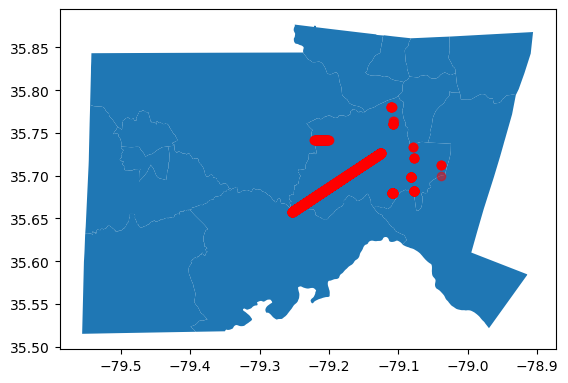

In [63]:
#checking an outlier case
fig, ax = plt.subplots(1, 1)
tract_gdf.loc[(tract_gdf['STATEFP']=='37') & (tract_gdf['COUNTYFP']=='037')].plot(ax=ax)
algae_mgd.loc[algae_mgd['GEOID']=='37037020800'].plot(ax=ax, color='red', alpha=0.5)

In [83]:
# merge to census data
census_df['GEOID'] = census_df['state'] + \
    census_df['county'].str.pad(3, side = 'left', fillchar = '0') + \
    census_df['tract'].str.pad(6, side = 'left', fillchar = '0')
algae_mgd_census = pd.merge(algae_mgd, census_df, on = "GEOID", how = "left")
algae_mgd_census

,uid,latitude,longitude,date,split,geometry,index_right,index,STATEFP,COUNTYFP,...,asian,hispanic_latino,state,county,tract,poverty_rate,percent_white,percent_black,percent_asian,percent_hispanic_latino
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032),51336.0,923.0,18,105,...,31.0,81.0,18,105,001402,0.056132,0.933486,0.005631,0.005455,0.014253
1,aabn,36.559700,-121.510000,2016-08-31,test,POINT (-121.51000 36.55970),40685.0,5472.0,06,053,...,0.0,5058.0,06,053,010804,0.111538,0.398976,0.000366,0.000000,0.924849
2,aacd,35.875083,-78.878434,2020-11-19,train,POINT (-78.87843 35.87508),19000.0,657.0,37,063,...,0.0,0.0,37,063,980100,NaN,NaN,NaN,NaN,NaN
3,aaee,35.487000,-79.062133,2016-08-24,train,POINT (-79.06213 35.48700),20276.0,1933.0,37,105,...,69.0,363.0,37,105,030702,0.092399,0.838871,0.109240,0.015703,0.082613
4,aaff,38.049471,-99.827001,2019-07-23,train,POINT (-99.82700 38.04947),69509.0,487.0,20,083,...,36.0,149.0,20,083,461100,0.089552,0.956290,0.000533,0.019190,0.079424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,POINT (-121.74900 36.70850),40684.0,5471.0,06,053,...,34.0,682.0,06,053,010306,0.026382,0.765704,0.015704,0.021357,0.428392
23566,zzwo,39.792190,-99.971050,2017-06-19,train,POINT (-99.97105 39.79219),69220.0,198.0,20,137,...,27.0,283.0,20,137,951700,0.094014,0.924165,0.027727,0.004958,0.051965
23567,zzwq,35.794000,-79.012551,2015-03-24,train,POINT (-79.01255 35.79400),18887.0,544.0,37,037,...,42.0,357.0,37,037,020702,0.077327,0.870871,0.087588,0.010511,0.089339
23568,zzyb,35.742000,-79.238600,2016-11-21,train,POINT (-79.23860 35.74200),19433.0,1090.0,37,037,...,8.0,283.0,37,037,020200,0.069754,0.831361,0.097292,0.000910,0.032203


In [84]:
algae_mgd_census['poverty_rate'] = algae_mgd_census['poverty'] / algae_mgd_census['total_pop']
algae_mgd_census['percent_white'] = algae_mgd_census['white'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_black'] = algae_mgd_census['black'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_asian'] = algae_mgd_census['asian'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_hispanic_latino'] = algae_mgd_census['hispanic_latino'] / algae_mgd_census['total_pop_race']

In [100]:
assert (algae_mgd_census.loc[algae_mgd_census['poverty_rate'].isna(), 'total_pop'] == 0).all()

In [101]:
constructs = ['poverty_rate', 'percent_white', 'percent_black', 'percent_asian', 'percent_hispanic_latino']
census_state_summ = census_df.groupby('state', as_index = False)[constructs].mean()
census_state_summ.columns = ['state'] + [i + "_state" for i in constructs]
census_state_summ

,state,poverty_rate_state,percent_white_state,percent_black_state,percent_asian_state,percent_hispanic_latino_state
0,01,0.168345,0.629139,0.321788,0.011160,0.040617
1,02,0.098187,0.628716,0.028743,0.057760,0.063468
2,04,0.139709,0.774349,0.042313,0.032215,0.305316
3,05,0.159840,0.734703,0.192895,0.012426,0.066940
4,06,0.122364,0.604868,0.058291,0.138479,0.380866
5,08,0.098256,0.847247,0.037534,0.029517,0.213503
6,09,0.095963,0.750618,0.114815,0.042953,0.169997
7,10,0.111348,0.691152,0.223111,0.035074,0.092316
8,11,0.146126,0.398569,0.485316,0.036713,0.102797
9,12,0.130531,0.762284,0.156440,0.024428,0.233372


In [104]:
algae_mgd_state = pd.merge(algae_mgd_census, census_state_summ, on = 'state', how = 'left')
# missing values are a population total = 0
algae_mgd_state.head()

,uid,latitude,longitude,date,split,geometry,index_right,index,STATEFP,COUNTYFP,...,poverty_rate,percent_white,percent_black,percent_asian,percent_hispanic_latino,poverty_rate_state,percent_white_state,percent_black_state,percent_asian_state,percent_hispanic_latino_state
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032),51336.0,923.0,18,105,...,0.056132,0.933486,0.005631,0.005455,0.014253,0.135398,0.815416,0.113403,0.018516,0.071056
1,aabn,36.559700,-121.510000,2016-08-31,test,POINT (-121.51000 36.55970),40685.0,5472.0,06,053,...,0.111538,0.398976,0.000366,0.000000,0.924849,0.122364,0.604868,0.058291,0.138479,0.380866
2,aacd,35.875083,-78.878434,2020-11-19,train,POINT (-78.87843 35.87508),19000.0,657.0,37,063,...,NaN,NaN,NaN,NaN,NaN,0.136625,0.688121,0.217392,0.025458,0.090968
3,aaee,35.487000,-79.062133,2016-08-24,train,POINT (-79.06213 35.48700),20276.0,1933.0,37,105,...,0.092399,0.838871,0.109240,0.015703,0.082613,0.136625,0.688121,0.217392,0.025458,0.090968
4,aaff,38.049471,-99.827001,2019-07-23,train,POINT (-99.82700 38.04947),69509.0,487.0,20,083,...,0.089552,0.956290,0.000533,0.019190,0.079424,0.115239,0.837549,0.066622,0.025983,0.124622


In [105]:
algae_mgd_census.to_csv("../data/algae_pts_with_tracts.csv")

## Code for hyperparameter tuning
* Note: most of this code is copied from the original [GitHub repository](https://github.com/apwheele/algaebloom), as we downsample the data.

In [15]:
from src import feat, mod
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
import numpy as np
import os
import pandas as pd
import pickle
from xgboost import XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor, Dataset
from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import ElasticNet

# Setting the global seed
np.random.seed(10)

# Just easier function to reset indices
def split(data,test_size=0.28,random_state=10):
    train, test = train_test_split(data,test_size=test_size,random_state=random_state)
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    return train, test

def split_weight(data,test_size=0.28,weight='pred_split',random_state=10):
    test = data.sample(test_size,weights='split_pred', random_state=random_state)
    train = data[~data['uid'].isin(test['uid'])].reset_index(drop=True)
    test.reset_index(drop=True,inplace=True)
    return train, test

# Just a wrapper around sklearn
# so it returns a pandas dataframe with named
# columns
class DumEnc():
    def __init__(self,dtype=int):
        self.OHE = OneHotEncoder(dtype=dtype,
                                 handle_unknown='ignore',
                                 sparse=False)
        self.var_names = None
    def fit(self, X):
        self.OHE.fit(X)
        cats = self.OHE.categories_
        var = list(X)
        vn = []
        for v,ca in zip(var,cats):
            for c in ca:
                vn.append(f'{v}_{c}')
        self.var_names = vn
    def transform(self,X):
        res = pd.DataFrame(self.OHE.transform(X),
                           columns=self.var_names,
                           index=X.index)
        return res

def dummy_stats(values,begin_date):
    vdate = pd.to_datetime(values,errors='ignore')
    year = vdate.dt.year
    month = vdate.dt.month
    week_day = vdate.dt.dayofweek
    diff_days = (vdate - begin_date).dt.days
    # if binary, turn week/month into dummy variables
    return diff_days, week_day, month, year

def circle_stats(values,begin_date):
    vdate = pd.to_datetime(values,errors='ignore')
    within_year = vdate.dt.dayofyear
    week_day = vdate.dt.dayofweek
    # calculate sine/cosine for within year
    year_cos = np.cos(within_year*(2*np.pi/365))
    year_sin = np.sin(within_year*(2*np.pi/365))
    # calculate sine/cosine for within week
    week_cos = np.cos(week_day*(2*np.pi/7))
    week_sin = np.sin(week_day*(2*np.pi/7))
    diff_days = (vdate - begin_date).dt.days
    return diff_days, year_cos, year_sin, week_cos, week_sin


class DateEnc():
    def __init__(self,
                 begin = '1/1/2015',
                 dummy = True,
                 dum_types=['days','weekday','month']):
        self.begin = pd.to_datetime(begin)
        self.dummy = dummy
        # 'days','weekday','month','year'
        self.dum_types = dum_types
        self.cat_vars = []
        # Setting categorical variables
    def fit(self,X):
        # These are just fixed functions
        pass
    def transform(self,X):
        vars = list(X)
        res = []
        res_labs = []
        cat_labs = []
        if self.dummy:
            for v in vars:
                dd, week_day, month, year = dummy_stats(X[v],self.begin)
                if 'days' in self.dum_types:
                    res.append(dd) # this is not likely to be categorical
                    res_labs.append(f'days_{v}')
                if 'weekday' in self.dum_types:
                    res.append(week_day)
                    res_labs.append(f'weekday_{v}')
                    cat_labs.append(f'weekday_{v}')
                if 'month' in self.dum_types:
                    res.append(month)
                    res_labs.append(f'month_{v}')
                    cat_labs.append(f'weekday_{v}')
                if 'year' in self.dum_types:
                    res.append(year)
                    res_labs.append(f'year_{v}')
                    cat_labs.append(f'year_{v}')
            self.cat_vars = cat_labs
        else:
             for v in vars:
                dd, year_cos, year_sin, week_cos, week_sin = circle_stats(X[v],self.begin)
                res += [dd, year_cos, year_sin, week_cos, week_sin]
                res_labs += [f'days_{v}',f'yearcos_{v}',f'yearsin_{v}',f'weekcos_{v}',f'weeksin_{v}']
        res_df = pd.concat(res,axis=1)
        res_df.index = X.index
        res_df.columns = res_labs
        return res_df


# Spline encoding
# defaults to regular knots
# or specified locations
class SplEnc():
    def __init__(self):
        pass
    def fit(self,X):
        pass
    def transform(self,X):
        pass


class IdentEnc():
    def __init__(self):
        self.note = None
    def fit(self,X):
        pass
    def transform(self,X):
        return X.copy()


class SimpleOrdEnc():
    def __init__(self,
                 dtype=int,
                 unknown_value=-1,
                 lim_k=None,
                 lim_count=None):
        self.unknown_value = unknown_value
        self.dtype = dtype
        self.lim_k = lim_k
        self.lim_count = lim_count
        self.vars = None
        self.soe = None
    def fit(self, X):
        self.vars = list(X)
        # Now creating fit for each variable
        res_oe = {}
        for v in list(X):
            res_oe[v] = OrdinalEncoder(dtype=self.dtype,
                handle_unknown='use_encoded_value',
                        unknown_value=self.unknown_value)
            # Get unique values minus missing
            xc = X[v].value_counts().reset_index()
            xc.columns = [v, "Freq"]
            # If lim_k, only taking top K value
            if self.lim_k:
                top_k = self.lim_k - 1
                un_vals = xc.loc[0:top_k,:]
            # If count, using that to filter
            elif self.lim_count:
                un_vals = xc[xc["Freq"] >= self.lim_count].copy()
            # If neither
            else:
                un_vals = xc
            # Now fitting the encoder for one variable
            res_oe[v].fit(un_vals[[v]])
        # Appending back to the big class
        self.soe = res_oe
    # Defining transform/inverse_transform classes
    def transform(self, X):
        xcop = X[self.vars].copy()
        for v in self.vars:
            xcop[v] = self.soe[v].transform( X[[v]].fillna(self.unknown_value) )
        return xcop
    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)
    def inverse_transform(self, X):
        xcop = X[self.vars].copy()
        for v in self.vars:
            xcop[v] = self.soe[v].inverse_transform( X[[v]].fillna(self.unknown_value) )
        return xcop

# You can compose multiple feature engines together
# Such as DateEnc() and DumEnc()
class ComposeFE():
    def __init__(self,
                mods):
        # expects a dictionary
        # of models
        self.mods = mods
    def fit(self,X):
        trans = X.copy()
        # goes left to right
        for k,m in self.mods.items():
            m.fit(trans)
            trans = m.transform(trans)
    def transform(self,X):
        trans = X.copy()
        for k,m in self.mods.items():
            trans = m.transform(trans)
        return trans


class FeatureEngine():
    def __init__(self,
                 ord_vars = None,
                 dum_vars = None,
                 spl_vars = None,
                 dat_vars = None,
                 ide_vars = None,
                 scale = None):
        self.fin_vars = None
        self.enc_dict = {}
        self.ord_vars = ord_vars
        self.dum_vars = dum_vars
        self.spl_vars = spl_vars
        self.dat_vars = dat_vars
        self.ide_vars = ide_vars
        self.cat_vars = None
        self.ord = SimpleOrdEnc()
        self.dum = DumEnc()
        self.dat = DateEnc()
        self.spl = SplEnc()
        self.ide = IdentEnc()
        self.scale = scale
        enc_vars = [ord_vars,dum_vars,spl_vars,dat_vars,ide_vars]
        enc_mods = [self.ord, self.dum, self.spl, self.dat, self.ide]
        for v,m in zip(enc_vars,enc_mods):
            if v is not None:
                self.enc_dict[tuple(v)] = m
    def fit(self, X):
        res = []
        for v,m in self.enc_dict.items():
            m.fit(X[list(v)])
            rf = m.transform(X[list(v)])
            res.append(rf)
        # doing a transform to know the variable names in the end
        res_df = pd.concat(res,axis=1)
        if self.scale is not None:
            self.scale.fit(res_df)
            res_df = pd.DataFrame(self.scale.transform(res_df),columns=list(res_df))
        self.fin_vars = list(res_df)
        # Adding categorical variables back in
        cat_vars = []
        if self.dum_vars is not None:
            cat_vars += self.dum.var_names
        if self.dat_vars is not None:
            cat_vars += self.dat.cat_vars
        if self.ord_vars is not None:
            cat_vars += self.ord_vars
        self.cat_vars = cat_vars
        return res_df
    def transform(self, X):
        res = []
        for v,m in self.enc_dict.items():
            res.append(m.transform(X[list(v)]))
        res_df = pd.concat(res,axis=1)
        if self.scale is not None:
            res_df = pd.DataFrame(self.scale.transform(res_df),columns=list(res_df))
        return res_df

def safelog(x):
    return np.log(x.clip(1))

def strat(values):
    edges = [np.NINF,20000,1e6,1e7,1e8,np.inf]
    labs = [1,2,3,4,5]
    res = pd.cut(values,bins=edges,labels=labs,right=False)
    return res.astype(int)


# Class to insert different types of
# regression models
class RegMod():
    def __init__(self,
                 ord_vars = None,
                 dum_vars = None,
                 dat_vars = None,
                 ide_vars = None,
                        y = None,
                transform = None,
                inv_trans = None,
                   weight = None,
                  scale_x = None,
                      mod = XGBRegressor(n_estimators=100, max_depth=3)):
        self.fe = FeatureEngine(ord_vars=ord_vars,
                           dat_vars=dat_vars,
                           dum_vars=dum_vars,
                           ide_vars=ide_vars,
                           scale = scale_x)
        self.transform = transform
        self.inv_trans = inv_trans
        self.mod = mod
        self.y = y
        self.resids = None
        self.cat_vars = None
        self.weight = weight
        self.metrics = None
        self.fit_cat = False
    def fit(self, X, weight=True, cat=True):
        if (self.weight is not None) & weight:
            sw = X[self.weight]
        else:
            sw = None
            #print('NOT using Weights in fit')
        y_dat = X[self.y].copy()
        if self.transform:
            y_dat = self.transform(y_dat)
        X_dat = self.fe.fit(X)
        self.cat_vars = self.fe.cat_vars
        # If catboost or lightgbm, pass in categories
        if (type(self.mod) == CatBoostRegressor) & cat:
            vt = list(X_dat)
            if self.cat_vars is not None:
                ci = [vt.index(c) for c in self.cat_vars]
            else:
                ci = None
            self.mod.fit(X_dat,y_dat,sample_weight=sw,cat_features=ci)
            self.fit_cat = True
        elif (type(self.mod) == LGBMRegressor) & cat:
            self.fit_cat = True
            for v in self.cat_vars:
                X_dat[v] = X_dat[v].astype('category')
            self.mod.fit(X_dat, y_dat, sample_weight=sw)
        else:
            self.mod.fit(X_dat,y_dat,sample_weight=sw)
        pred = self.mod.predict(X_dat)
        self.resids = pd.Series(y_dat - pred)
    def predict(self,X,duan=True):
        X_dat = self.fe.transform(X)
        if self.fit_cat & (type(self.mod) == LGBMRegressor):
            for v in self.cat_vars:
                X_dat[v] = X_dat[v].astype('category')
        pred = pd.Series(self.mod.predict(X_dat), X.index)
        resids = self.resids
        # if transform, do Duans smearing
        if (self.transform is not None) & duan:
            resids = resids.values.reshape(1,resids.shape[0])
            dp = self.inv_trans(pred.values.reshape(X.shape[0],1) + resids)
            pred = pd.Series(dp.mean(axis=1), X.index)
        return pred
    def predict_int(self,X):
        pred = self.predict(X)
        if self.transform:
            pred = strat(pred)
        pred = pred.clip(1,5).round().astype(int)
        return pred
    def feat_import(self):
        var_li = self.fe.fin_vars
        mod_fi = self.mod.feature_importances_
        res_df = pd.DataFrame(zip(var_li,mod_fi),columns = ['Var','FI'])
        res_df.sort_values('FI',ascending=False,inplace=True,ignore_index=True)
        # Normalize to sum to 1
        res_df['FI'] = res_df['FI']/res_df['FI'].sum()
        return res_df
    def met_eval(self, data, weight=True, cat=True, full_train=False,
                 split_tt='weighted', test_size=500, test_splits=10, 
                 ret=False, pr=False):
        dc = data.copy()
        seeds = np.random.randint(1,1e6,test_splits)
        metrics = []
        for s in seeds:
            if split_tt == 'weighted':
                if self.weight is not None:
                    wv = self.weight
                else:
                    wv = 'pred_split'
                train, test = split_weight(dc,test_size,wv,s)
            else:
                train, test = split(dc,test_size,s)
            self.fit(train, weight, cat)
            test['pred'] = self.predict_int(test)
            met_di = rmse_region(test,ret=True)
            met_di['seed'] = s
            metrics.append(met_di.copy())
        mpd = pd.DataFrame(metrics)
        if full_train:
            self.fit(data)
        if self.metrics is None:
            self.metrics = mpd
        else:
            self.metrics = pd.concat([self.metrics,mpd],axis=0)
        if pr:
            print(mpd[['AvgError','midwest','northeast','south','west']].describe().T)
        if ret:
            return mpd['AvgError'].mean()

class CatMod():
    def __init__(self,
                 ord_vars = None,
                 dum_vars = None,
                 dat_vars = None,
                 ide_vars = None,
                        y = None,
                transform = None,
                inv_trans = None,
                  scale_x = None,
                      mod = CatBoostClassifier(iterations=100,depth=5,allow_writing_files=False,verbose=False)
                      ):
        self.fe = FeatureEngine(ord_vars=ord_vars,
                           dat_vars=dat_vars,
                           dum_vars=dum_vars,
                           ide_vars=ide_vars,
                           scale = scale_x)
        self.mod = mod
        self.y = y
        self.cat_vars = None
    def fit(self, X, sample_weight=None):
        y_dat = X[self.y].copy().astype(int)
        X_dat = self.fe.fit(X)
        self.mod.fit(X_dat,y_dat,sample_weight=sample_weight)
    def predict_proba(self,X):
        X_dat = self.fe.transform(X)
        pred_probs = self.mod.predict_proba(X_dat)
        # Turning into nicer dataframe
        cols = [f'P{str(i)}' for i in range(pred_probs.shape[1])]
        pred_probs = pd.DataFrame(pred_probs,index=X.index, columns=cols)
        return pred_probs
    def predict(self,X):
        # returns predicted probability
        pred = self.predict_proba(X)
        return pred["P1"]
    def feat_import(self):
        var_li = self.fe.fin_vars
        mod_fi = self.mod.feature_importances_
        res_df = pd.DataFrame(zip(var_li,mod_fi),columns = ['Var','FI'])
        res_df.sort_values('FI',ascending=False,inplace=True,ignore_index=True)
        # Normalize to sum to 1
        res_df['FI'] = res_df['FI']/res_df['FI'].sum()
        return res_df

# If you pass in multiple models
# this will ensemble them, presumes regressor models
class EnsMod():
    def __init__(self, mods, av_func = 'mean'):
        self.mods = mods #should be dict
        self.av_func = av_func
    def fit(self,X,weight=True,cat=True):
        for key,mod in self.mods.items():
            mod.fit(X,weight=weight,cat=cat)
    def predict(self,X):
        res = []
        for key,mod in self.mods.items():
            res.append(mod.predict(X))
        res_df = pd.concat(res,axis=1)
        if self.av_func == 'mean':
            pred = res_df.mean(axis=1)
        return pred
    def predict_int(self,X):
        pred = self.predict(X)
        pred = pred.clip(1,5).round().astype(int)
        return pred

def rmse_region(data,pred='pred',true='severity',region='region',scale=False,ret=False):
    dc = data[[region,true,pred]].copy()
    if scale:
        dc[pred] = strat(dc[pred])
    dc[pred] = dc[pred].round().astype(int).clip(1,5)
    dc[region] = dc[region].replace({1:'northeast',
                                     2:'south',
                                     3:'midwest',
                                     4:'west'})
    dc['sq_error'] = (dc[true] - dc[pred])**2
    gr_val = dc.groupby(region,as_index=False)['sq_error'].mean()
    gr_val['root_mse'] = np.sqrt(gr_val['sq_error'])
    avg_error = gr_val['root_mse'].mean()
    if ret:
        regions = gr_val['region'].tolist()
        regions.append('AvgError')
        vals = gr_val['root_mse'].tolist()
        vals.append(avg_error)
        gr_di = {r:v for r,v in zip(regions,vals)}
        return gr_di
    else:
        print(f'\nAverage error {avg_error:.4f}')
        print('\nRegion Error')
        print(gr_val[['region','root_mse']])

def save_model(mod,name):
    fname = f'./models/{name}.pkl'
    outfile = open(fname,"wb")
    pickle.dump(mod,outfile)
    outfile.close()

def load_model(name):
    fname = f'./models/{name}.pkl'
    infile = open(fname, "rb")
    mod = pickle.load(infile)
    infile.close()
    return mod


# function to check if similar to any past submissions
def check_similar(current):
    files = os.listdir("./submissions")
    for fi in files:
        old = pd.read_csv(f"./submissions/{fi}")
        dif = np.abs(current['severity'] - old['severity']).sum()
        if dif == 0:
            print(f'Date {fi} same as current')


def check_day(current,day="sub_2023_01_31.csv"):
    old = pd.read_csv(fr"./submissions/{day}")
    dstr = f'dif_{day[4:-4]}'
    current[dstr] = old['severity'] - current['severity']
    print(current[dstr].value_counts())

In [17]:
def today_str():
    now = datetime.now()
    return now.strftime('%Y_%m_%d')


reg_ord = {'west':4,
           'midwest':3,
           'south':2,
           'northeast':1}

# ordinal encoding for region
def org_reg(data,rstr='region'):
    data[rstr] = data[rstr].replace(reg_ord)

def filter_reg(data, region):
    return data.loc[data['region']==region]

def subsample(data, n):
    nrows = data.shape[0]
    stratified_sample, _ = train_test_split(data, test_size=1 - (n/nrows), stratify=data['region'])
    return stratified_sample

def filter_time(data):
    return data.loc[data['date'].dt.year > 2016]

def ord_imtype(data,imstr='imtype'):
    rep_di = {'land_sat':0,
              'sentinel':1}
    data[imstr] = data[imstr].fillna(-1).replace(rep_di)


def filter_landsat(data):
    rep_di = {'land_sat':0,
              'sentinel':1}
    data['imtype'] = data['imtype'].fillna(-1).replace(rep_di)
    im_vars = ['prop_lake_500', 'r_500', 'g_500', 'b_500']
    im_vars += ['prop_lake_1000', 'r_1000', 'g_1000', 'b_1000']
    im_vars += ['prop_lake_2500', 'r_2500', 'g_2500', 'b_2500']
    im_vars += ['imtype']
    landsat = data['imtype'] == 0
    data.loc[landsat,im_vars] = -1

def safesqrt(values):
    return np.sqrt(values.clip(0))

def safelog(x):
    return np.log(x.clip(1))

def strat(values):
    edges = [np.NINF,20000,1e6,1e7,1e8,np.inf]
    labs = [1,2,3,4,5]
    res = pd.cut(values,bins=edges,labels=labs,right=False)
    return res.astype(int)

# Looking at train/test
# there are a few clusters, want
# to make sure to predict these well
def cluster(x):
    lat, lon = x[0], x[1]
    if (lat < 41) & (lon < -116):
        # cali
        return 7
    elif (lat < 41) & (lat > 36.29) & (lon < -92.9) & (lon > -102.2):
        # midwest
        return 6
    elif (lat < 38.14) & (lat > 33.26) & (lon < -74.8) & (lon > -85.52):
        # carolina
        return 2
    elif (lat < 43) & (lat > 38.7) & (lon < -75.4) & (lon > -83.55):
        # erie
        return 3
    elif (lat < 43.1) & (lat > 40.7) & (lon < -69.5) & (lon > -74.6):
        # mass
        return 4
    elif (lat < 49.6) & (lat > 41.5) & (lon < -83.55) & (lon > -104.56):
        # dakota
        return 1
    else:
        # other
        return 5

#                  1   2      2   3    3     4   4    5   5
#te_st = pd.Series([1,20000,30000,1e6,1e6+1,1e7,1e7+1,1e8,1e9])
#print(strat(te_st))

db = './data/data.sqlite'

train_query = """
SELECT 
  m.uid,
  l.region,
  l.severity,
  l.density,
  m.latitude,
  m.longitude,
  m.date,
  e.elevation,
  e.mine,
  e.maxe,
  e.dife,
  e.avge,
  e.stde,
  sl.severity_100,
  sl.logDensity_100,
  sl.count_100,
  sl.severity_300,
  sl.logDensity_300,
  sl.count_300,
  sl.severity_1000,
  sl.logDensity_1000,
  sl.count_1000,
  st.imtype,
  st.prop_lake_500,
  st.r_500,
  st.g_500,
  st.b_500,
  st.prop_lake_1000,
  st.r_1000,
  st.g_1000,
  st.b_1000,
  st.prop_lake_2500,
  st.r_2500,
  st.g_2500,
  st.b_2500
FROM meta AS m
LEFT JOIN elevation_dem AS e
  ON m.uid = e.uid
LEFT JOIN spat_lag AS sl
  ON m.uid = sl.uid
LEFT JOIN sat AS st
  ON m.uid = st.uid
LEFT JOIN labels AS l
  ON m.uid = l.uid
WHERE
  m.split = 'train'
"""

test_query = """
SELECT 
  m.uid,
  l.region,
  m.latitude,
  m.longitude,
  m.date,
  e.elevation,
  e.mine,
  e.maxe,
  e.dife,
  e.avge,
  e.stde,
  sl.severity_100,
  sl.logDensity_100,
  sl.count_100,
  sl.severity_300,
  sl.logDensity_300,
  sl.count_300,
  sl.severity_1000,
  sl.logDensity_1000,
  sl.count_1000,
  st.imtype,
  st.prop_lake_500,
  st.r_500,
  st.g_500,
  st.b_500,
  st.prop_lake_1000,
  st.r_1000,
  st.g_1000,
  st.b_1000,
  st.prop_lake_2500,
  st.r_2500,
  st.g_2500,
  st.b_2500
FROM meta AS m
LEFT JOIN elevation_dem AS e
  ON m.uid = e.uid
LEFT JOIN spat_lag AS sl
  ON m.uid = sl.uid
LEFT JOIN sat AS st
  ON m.uid = st.uid
LEFT JOIN format AS l
  ON m.uid = l.uid
WHERE
  m.split = 'test'
"""

def add_table(data,tab_name,db_str=db):
    db_con = sqlite3.connect(db_str)
    dn = data.copy()
    dn['DateTime'] = pd.to_datetime('now',utc=True)
    dn.to_sql(tab_name,index=False,if_exists='replace',con=db_con)


def get_both(db_str=db,split_pred=False):
    r1 = get_data('train',db_str,split_pred)
    r1['test'] = 0
    r1.drop(columns=['severity','density','logDensity'],inplace=True)
    r2 = get_data('test',db_str,split_pred)
    r2['test'] = 1
    res_df = pd.concat([r1,r2],axis=0)
    return res_df.reset_index(drop=True)

def get_data(region, data_type='train',db_str=db,split_pred=False):
    db_con = sqlite3.connect(db_str)
    if data_type == 'train':
        sql = train_query
    elif data_type == 'test':
        sql = test_query
    dat = pd.read_sql(sql,con=db_con)
    org_reg(dat) # Region ordinal encode
    # Winning solution used landsat-7 data
    #ord_imtype(dat) # image type landsat/sentinel
    filter_landsat(dat) # filtering mistake landsat-7 info
    dat = dat.fillna(-1) # missing a bit of sat data
    dat['cluster'] = dat[['latitude','longitude']].apply(cluster,axis=1)
    dat['date'] = pd.to_datetime(dat['date'])
    dat = filter_time(dat) # filter for year > 2016
    dat = subsample(dat, 3000)
    if data_type == 'train':
        dat['logDensity'] = safelog(dat['density'])
    if split_pred:
        pred_test = pd.read_sql('SELECT uid, pred AS split_pred FROM split_pred',con=db_con)
        dat = dat.merge(pred_test,on='uid')
    return dat


# Need logic to take predictions and get them in the right order
def sub_format(data,pred='pred'):
    form = pd.read_csv('./data/submission_format.csv')
    # some logic to transform predictions via Duan
    # smearing
    dp = data[[pred,'uid']].copy()
    dp[pred] = dp[pred].round().astype(int).clip(1,5)
    mf = form.merge(dp,on='uid')
    mf['severity'] = mf['pred']
    return mf[['uid','region','severity']]

In [18]:
train_dat = get_data(1, split_pred=True)
print("num rows:", train_dat.shape[0])
train_dat.head()

num rows: 3000


,uid,region,severity,density,latitude,longitude,date,elevation,mine,maxe,...,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500,cluster,logDensity,split_pred
0,qpqb,4,4,6.222500e+06,37.248600,-120.851000,2020-04-14,23.087214,18.154081,24.670233,...,92.365201,89.450150,64.195302,0.053294,115.329547,108.669310,80.993142,7,15.643682,0.001563
1,ejje,4,1,3.300000e+03,41.226600,-123.771900,2018-09-26,60.853107,39.500000,403.658112,...,91.245601,84.801836,58.868018,0.041040,85.152474,81.820063,52.591304,5,8.101678,0.019628
2,ustf,3,2,6.613748e+04,41.477230,-92.460280,2017-06-20,241.500000,231.107132,279.435547,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,5,11.099491,0.175481
3,tmtu,2,2,2.178400e+04,35.667065,-79.235893,2017-01-24,130.805252,99.000000,163.223160,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2,9.988931,0.001410
4,vhmm,2,1,1.129500e+04,35.692455,-79.188733,2017-11-15,136.953354,111.393166,177.021301,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2,9.332115,0.003837


In [19]:
# Example just predicting severity directly
sat_500 = ['prop_lake_500', 'r_500', 'g_500', 'b_500']
sat_1000 = ['prop_lake_1000', 'r_1000', 'g_1000', 'b_1000']
sat_2500 = ['prop_lake_2500', 'r_2500', 'g_2500', 'b_2500']
sat_1025 = ['prop_lake_2500', 'r_2500', 'g_2500', 'b_2500', 
           'prop_lake_1000', 'r_1000', 'g_1000', 'b_1000']

### Tuning
* Only tuning LightBoostGM and XGBoost (CatBoost must be run overnight and we have code in a separate notebook for that)
* Sub-sampling 3,000 rows from the original training dataset, filtered for year > 2016
* Using 500 rows as the test dataset
* All code comes from the original repository with slight modifications

In [20]:
import optuna

res_results = {}

In [21]:
# Model fit with weights
weight_cats = tuple([False])

# Model fit with categorical variables
cat_cats = (True,False)

# Lat/Lon included in model
xy_cats = {'no': [],
           'both': ['latitude','longitude'],
           'lat': ['latitude'],
           'lon': ['longitude']}

xy_keys = tuple(xy_cats.keys())

# Region variables
region_cats = {'both': ['region','cluster'],
               'reg':  ['region'],
               'clust':  ['cluster']}

reg_keys = tuple(region_cats.keys())

# Elevation Variables
ele_cats = {'max_dif':['maxe','dife'],
            'all_var':['maxe','dife','elevation','stde'],
            'ele_std':['elevation','stde'],
            'ele_dif':['elevation','dife'],
            'max_std':['maxe','stde'] }

ele_keys = tuple(ele_cats.keys())

In [22]:
# Spatial Lag Variables
sl_cats = {#'lag100': ['severity_100','logDensity_100','count_100'],
           #'lag300': ['severity_300','logDensity_300','count_300'],
           #'lag1000': ['severity_1000','logDensity_1000','count_1000'],
           'lagNone': []}

sl_keys = tuple(sl_cats.keys())

# Sat imagery data
sat_cats = {'sat500': ['imtype','prop_lake_500','r_500','g_500','b_500'],
            'sat1000': ['imtype','prop_lake_1000','r_1000','g_1000','b_1000'],
            'sat2500': ['imtype','prop_lake_2500','r_2500','g_2500','b_2500'],
            'sat500_1000': ['imtype','prop_lake_500','r_500','g_500','b_500', 'prop_lake_1000','r_1000','g_1000','b_1000'],
            'sat500_2500': ['imtype','prop_lake_500','r_500','g_500','b_500', 'prop_lake_2500','r_2500','g_2500','b_2500'],
            'sat1000_2500': ['imtype','prop_lake_1000','r_1000','g_1000','b_1000', 'prop_lake_2500','r_2500','g_2500','b_2500']}

sat_keys = tuple(sat_cats.keys())


In [23]:
def objective_lgb(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "ele_set": trial.suggest_categorical("ele_vars", ele_keys),
        "xy_set": trial.suggest_categorical("xy_set", xy_keys),
        "sl_set": trial.suggest_categorical("sl_set", sl_keys),
        "reg_set": trial.suggest_categorical("reg_set", reg_keys),
        "weight": trial.suggest_categorical("weight", weight_cats),
        "cat_type": trial.suggest_categorical("cat_type", cat_cats),
        "sat_set": trial.suggest_categorical("sat_set", sat_keys),
    }
    # Setting the different variables
    ov = region_cats[param['reg_set']]
    #if 'imtype' in sat_cats[param['sat_set']]:
    #    ov.append('imtype')
    cv = ele_cats[param['ele_set']] + xy_cats[param['xy_set']]
    cv += sl_cats[param['sl_set']]
    cv += sat_cats[param['sat_set']]
    rm = mod.RegMod(ord_vars=ov,
                    dum_vars=None,
                    dat_vars=['date'],
                    ide_vars=cv,
                    weight = 'split_pred',
                    y='severity',
                    mod = mod.LGBMRegressor(n_estimators=round(param['n_estimators']),
                                            max_depth=param['max_depth']))
    avg_rmse = rm.met_eval(train_dat,ret=True,weight=param['weight'],cat=param['cat_type'])
    return avg_rmse

study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=300) # 150
trial_lgb = study_lgb.best_trial
res_results['lgb'] = trial_lgb

[I 2023-04-17 21:06:06,592] A new study created in memory with name: no-name-e24a7005-dac7-41bc-9be6-718ef035e94e
[I 2023-04-17 21:06:07,317] Trial 0 finished with value: 0.9239777787095184 and parameters: {'n_estimators': 90, 'max_depth': 3, 'ele_vars': 'all_var', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': False, 'sat_set': 'sat1000'}. Best is trial 0 with value: 0.9239777787095184.
[I 2023-04-17 21:06:08,724] Trial 1 finished with value: 0.9737804736733914 and parameters: {'n_estimators': 220, 'max_depth': 5, 'ele_vars': 'ele_std', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'clust', 'weight': False, 'cat_type': True, 'sat_set': 'sat2500'}. Best is trial 0 with value: 0.9239777787095184.
[I 2023-04-17 21:06:10,132] Trial 2 finished with value: 1.0121661918665192 and parameters: {'n_estimators': 460, 'max_depth': 2, 'ele_vars': 'ele_std', 'xy_set': 'lat', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': True, 'sat_set

In [24]:
def objective_xgb(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "ele_set": trial.suggest_categorical("ele_vars", ele_keys),
        "xy_set": trial.suggest_categorical("xy_set", xy_keys),
        "sl_set": trial.suggest_categorical("sl_set", sl_keys),
        "reg_set": trial.suggest_categorical("reg_set", reg_keys),
        "weight": trial.suggest_categorical("weight", weight_cats),
        "sat_set": trial.suggest_categorical("sat_set", sat_keys),
    }
    # Setting the different variables
    ov = region_cats[param['reg_set']]
    #if 'imtype' in sat_cats[param['sat_set']]:
    #    ov.append('imtype')
    cv = ele_cats[param['ele_set']] + xy_cats[param['xy_set']]
    cv += sl_cats[param['sl_set']]
    cv += sat_cats[param['sat_set']]
    rm = mod.RegMod(ord_vars=ov,
                    dum_vars=None,
                    dat_vars=['date'],
                    ide_vars=cv,
                    weight = 'split_pred',
                    y='severity',
                    mod = mod.XGBRegressor(n_estimators=round(param['n_estimators']),
                                           max_depth=param['max_depth'])
                )
    avg_rmse = rm.met_eval(train_dat,ret=True,weight=param['weight'])
    return avg_rmse

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=300)
trial_xgb = study_xgb.best_trial
res_results['xgb'] = trial_xgb

[I 2023-04-17 21:10:27,680] A new study created in memory with name: no-name-e108dcef-34df-47ac-84bc-bb5d5617a295
[I 2023-04-17 21:10:32,021] Trial 0 finished with value: 1.0601975571659343 and parameters: {'n_estimators': 420, 'max_depth': 10, 'ele_vars': 'all_var', 'xy_set': 'no', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'sat_set': 'sat2500'}. Best is trial 0 with value: 1.0601975571659343.
[I 2023-04-17 21:10:35,891] Trial 1 finished with value: 1.060400335802416 and parameters: {'n_estimators': 310, 'max_depth': 9, 'ele_vars': 'max_dif', 'xy_set': 'no', 'sl_set': 'lagNone', 'reg_set': 'reg', 'weight': False, 'sat_set': 'sat1000_2500'}. Best is trial 0 with value: 1.0601975571659343.
[I 2023-04-17 21:10:37,338] Trial 2 finished with value: 1.0136760769554074 and parameters: {'n_estimators': 140, 'max_depth': 2, 'ele_vars': 'all_var', 'xy_set': 'both', 'sl_set': 'lagNone', 'reg_set': 'reg', 'weight': False, 'sat_set': 'sat1000'}. Best is trial 2 with value: 1.01367607

In [ ]:
print(f"Best Average RMSE LightBoost {trial_lgb.value}")
print("Best Params")
print(trial_lgb.params)

In [ ]:
print(f"Best Average RMSE XGBoost {trial_xgb.value}")
print("Best Params")
print(trial_xgb.params)